# Setup

In [1]:
# Third-party imports
import pandas as pd
%matplotlib inline
from ipywidgets import interact
import getpass

# Local packages
from database import connect
from populations import pop_queries
import queries
import analysis
import compute_stats
import plots
from params import key_list, comparison_pairs, filepath_dictionary, field_list_dict

## Connecting to an SQL database with Python

### Oracle Instant Client - Installation instructions

Interacting with an Oracle RDBMS requires Oracle Client libraries to be installed. You can read more about this [here](https://oracle.github.io/odpi/doc/installation.html). 

In general, Oracle Client libraries come with your Oracle Database installation or full Oracle Client installation. To connect to an Oracle RDBMS using Python, you need to install Oracle Instant Client. We will describe only one of the many possible ways to install Oracle Instant Client in a way that allows you to access an Oracle Database using Python from your local machine. Please follow the installation instructions below:

1. **Download the Oracle Instant Client zip files.** You can find the appropriate installer for your machine [here](https://oracle.github.io/odpi/doc/installation.html). For example, for Windows 64-bit machines you will be directed to download the Oracle Instant Client Basic Package from [this webpage](https://www.oracle.com/database/technologies/instant-client/winx64-64-downloads.html).
2. **Install the libraries where Python can read them.** Copy the contents of the `instantclient_19_3` folder (found inside the zipped folder you have just downloaded) to `C:\Users\<username>\AppData\Local\Continuum\miniconda3\envs\<my_conda_environment>\DLLs`

Step 2 assumes you used [Miniconda3](https://docs.conda.io/en/latest/miniconda.html) to install the `conda` package manager (and Python 3), and that you set up a custom environment for your project rather than using the base environment (highly recommended), but this should be generalizable. In particular, copying the contents of `instantclient_19_3` to the folder `C:\Users\<username>\AppData\Local\Continuum\miniconda3\DLLs` would install the Oracle Instant Client libraries into your base environment.

These instructions are somewhat Windows-centric, and in fact, if you have Python running already, you could install the files into any folder on your `PYTHONPATH`, which you can find out about by running `import sys; print(sys.path)` in Python. The specific folder location in this tutorial was chosen since it is a natural place to install [.dll files](https://whatis.techtarget.com/fileformat/DLL-Dynamic-link-library-file) such as those which comprise the Oracle Instant Client.

### Log into the database

In [ ]:
username = 'analysisedwardpearce'  # input('username:')
db = connect(username, getpass.getpass('password:'))

## Working locally

### Writing

In [ ]:
# from write_results import write_counts_to_csv

# for count_type in field_list_dict.keys():
#     for key in key_list:
#         write_counts_to_csv(count_type, key, db)

### Reading

In [2]:
count_types = ['univariate_categorical', 'univariate_dates', 'bivariate_categorical', 
               'categorical_cross_diagnosis_date', 'categorical_cross_surgery_date', 'surgery_date_cross_diagnosis_date']
combined_counts = {count_type: analysis.combine_counts(count_type, analysis.read_counts(count_type)) 
                   for count_type in count_types}

C:\Users\edward.pearce\AppData\Local\Continuum\miniconda3\envs\idp\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



#### Basic metadata

Having successfully read the counts data above, and joined the counts data from tables we wish to compare, we can check the sizes of the resulting tables and that the sum of category sizes within each field is equal to the number of rows in the corresponding source data table as we would expect.

In [ ]:
joined_table_sizes = pd.DataFrame({count_type: {pair[0]+' vs. '+pair[1]: frame.shape for pair, frame in comparison_tables.items()} for count_type, comparison_tables in combined_counts.items()}).T
joined_table_sizes

In [ ]:
from compute_stats import pop_sizes

def check_pop_sizes():
    for pair, comparison_table in combined_counts['univariate_categorical'].items():
        totals_by_category = comparison_table.groupby(by='column_name').sum()
        for key in pair:
            check = (totals_by_category['counts_'+key] == pop_sizes[key]).all()
            print('The number of data entries in the {} cohort is {}: {}'.format(key, pop_sizes[key], check))

check_pop_sizes()

# Preliminary checks on counts data

Some cases of particular interest may include:
- Simulated values which are not present in the real dataset (although we typically wouldn't worry about this in the case of datetime fields). Such values could not have been sampled from the real data, and statistical tests cannot be meaningfully carried out on these values since they are not expected to occur at all based on the real data.
- Real values which are not present in the simulated dataset. Sometimes this can be explained as reasonable if the values are themselves rare in the real data, however this can also help to identify values which are being significantly underrepresented in the simulated data.

## Using Python's Pandas package

In [ ]:
def join_comparison_tables(count_type, combined_counts):
    # Repeat the process of joining tables and filling in the missing zeros
    all_joined = pd.merge(combined_counts[count_type][comparison_pairs[0]], combined_counts[count_type][comparison_pairs[1]], 
                          on=analysis.join_cols[count_type], how='outer')
    count_cols = ['counts_'+key for key in key_list]
    all_joined[count_cols] = all_joined[count_cols].fillna(0, axis=1).astype('uint32')
    return all_joined

def check_zeros(table, ignore=['DATE_FIRST_SURGERY', 'DIAGNOSISDATEBEST']):
    check = (table == 0).any(axis=1)
    for field in ignore:
        check = check & (table.column_name != field)
    return table.loc[check]

In [ ]:
interact(lambda col_name: check_zeros(join_comparison_tables('univariate_categorical', combined_counts)).query("column_name == '{}'".format(col_name)), col_name=field_list_dict['univariate_categorical'])

## Joining directly in SQL

In [ ]:
totals_comb = pd.read_sql_query(queries.all_counts_query(pop_queries['sim1'], pop_queries['av2015']), db)
print(totals_comb.shape)

In [ ]:
totals_comb2 = pd.read_sql_query(queries.all_counts_query(pop_queries['sim2'], pop_queries['av2017']), db)
print(totals_comb2.shape)

In [ ]:
totals_comb.head(10)

In [ ]:
totals_comb2.head(10)

In [ ]:
totals_comb.query("counts_r == 0").tail(10)

In [ ]:
totals_comb.query("(counts_s == 0) and (counts_r >= 10)")

In [ ]:
interact(lambda col_name: totals_comb.query("col_name == '{}'".format(col_name)), col_name=field_list_dict['univariate_categorical']+field_list_dict['univariate_dates']);

# Statistical Tests (Theory)

## Binomial test: Approximation by z-test

### One-sample z-test with binomial assumption

We test the null hypothesis 

$$H_0: X_{C}\sim\mathrm{Bin}(n,\hat{p}_{C})$$ 

that the occurrence $X_{C}$ of category $C$ in the simulated tumour dataset was sampled from a binomial distribution $\mathrm{Bin}(n,\hat{p}_{C})$ where $n$ is the number of simulated tumour entries/rows and $\hat{p}_{C}$ is the proportion of real tumour entries which fall into category $C$, against the alternative hypothesis that the simulated dataset was sampled in some other way (e.g. $X$ binomially distributed with a different value of $p$; $X$ not binomially distributed because $p$ not constant between trials or trials not independent, etc). 

If n is large enough, then the skew of the Binomial distribution is not too great. In this case a reasonable approximation to $B(n, p)$ is given by the normal distribution $\mathcal{N}(np,np(1-p))$. - [Wikipedia](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation)

In this case we may use the test statistic 

$$z = \frac{X - np}{\sqrt{np(1-p)}}\sim\mathcal{N}(0,1)$$

#### When is the normal approximation appropriate?

We apply the rule which states that the normal approximation is appropriate only if everything within 3 standard deviations of its mean is within the range of possible values; that is, only if

$$\mu \pm 3\sigma =np\pm 3{\sqrt {np(1-p)}}\in (0,n)$$

This 3-standard-deviation rule is equivalent to the following conditions:

$$n>9\left({\frac {1-p}{p}}\right)\quad {\text{and}}\quad n>9\left({\frac {p}{1-p}}\right)$$

The code below draws a graph to illustrate how the continous normal distribution approximates the discrete binomial distribution. The vertical lines show the probability mass functions of different binomial distributions whilst the smooth black lines show the probability distribution functions of their corresponding approximating normal distributions, which are based on the mean and variances of their respective binomial distibution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm
fig, ax = plt.subplots(1, 1, figsize=(15,10))

n = 40
colors = ['b', 'y', 'r']
probs = [0.7, 0.9, 0.99]
binom_dists = [binom(n, p) for p in probs]
moments = [drv.stats(moments='mv') for drv in binom_dists]
norm_dists = [norm(loc=mv[0], scale=np.sqrt(mv[1])) for mv in moments]

x = np.arange(20, 41)
#x = [np.arange(drv.ppf(0.005), drv.ppf(0.995)) for drv in binom_dists]
x1 = [np.linspace(crv.ppf(0.005), crv.ppf(0.995), 100) for crv in norm_dists]

for i in range(len(probs)):
    ax.vlines(x, 0, binom_dists[i].pmf(x), color=colors[i], label='p = {} and n = {}'.format(probs[i], n))
    ax.plot(x1[i], norm_dists[i].pdf(x1[i]), 'k')
ax.set_xlabel('$x$', fontsize = 24) 
ax.set_ylabel('$P(X=x)$', fontsize = 24) 
ax.set_title('Binomial distributions and their Normal approximations', fontsize = 24) 
ax.legend()
plt.show()

Notice that the as the success probability $p$ gets closer to $0$ or $1$, the binomial distribution gets more skewed/less symmetric, and matches up less well with its normal approximation (which is always symmetric about its mean value). In these extreme cases, the normal approximation also assigns nontrivial probabilities to impossible events under the binomial setup (i.e. more success than trials, or negative number of successes). 

For these reasons, using the z-test statistic in these cases may lead to misleading results, namely an increased number of Type I errors - rejecting a true null hypothesis, which in our case means identifying more simulated categories as failing to closely match their real counterparts than is truely the case.

We may wish to check the feasibility of calculating the exact binomial test statistics using SciPy in some cases.

Sample code:
`scipy.stats.binom_test(51, 235, 1.0/6, alternative='two-sided')`

### Pooled two-sample z-test with binomial assumption

Assuming first that the occurrence of category $C$ in the real and simulated datasets are each binomially distributed (with number of trials equal to the number of data entries/rows), the pooled two-sample z-test tests the null hypothesis that these binomial distribitions both have the same underlying success probability parameter $p$. 

We are modelling the number of occurrences $X_{1}, X_{2}$ of category $C$ in the simulated (resp. real) datasets by $X_{i}\sim\mathrm{Bin}(n_{i},p_{i})$, where $n_{1}$ ($n_{2}$) is the number of rows in the simulated (real) dataset, $p_{1}$ ($p_{2}$) is the probability of a data row falling into category $C$ when the simulated (resp. real) dataset was sampled/obtained, respectively.

The null hypothesis is $$H_0: p_{1} = p_{2} = p$$ 

We estimate the probabilities $p_{1}, p_{2}$ by the proportions $\hat{p}_{i} = X_{i}/n_{i}$ of occurences of category $C$ in the simulated (real) dataset, respectively. If the null hypothesis is true, our best estimate for $p$ is $$\hat{p} = \frac{X_{1} + X_{2}}{n_{1} + n_{2}}$$

We have the following test statistic:

$$z = \frac{\hat{p}_{1} - \hat{p}_{2}}{\sqrt{\hat{p}(1 - \hat{p})(\frac{1}{n_{1}} + \frac{1}{n_{2}})}}\sim\mathcal{N}(0,1)$$

This test has the advantage of still being calculable in the case that $\hat{p}_{2}=0, \hat{p}_{1}\ne0$ due to zero occurences of a particular value/category in the real data, which might reasonably occur in the case of date fields and some fields relating to rare cancers. The previous one-sample z-test would produce an infinite test statistic when $X\ne0$ due to dividing by zero, which indicates an expected number of entries in the given category being exactly 0 with absolute certainty.

For more details, see the explanation [here](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Tests_for_Two_Proportions.pdf).

## Pearson's chi-squared test and Likelihood-ratio/G-test for each field

You can read the Wikipedia pages for background on the various kinds of [multinomial test](https://en.wikipedia.org/wiki/Multinomial_test), namely:
- [Pearson's chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
![Pearson's chi-squared test](https://wikimedia.org/api/rest_v1/media/math/render/svg/c4fd8945d1bdd2aa3cc133571cb8bb0b232fac3b)
- [Likelihood-ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test) (a.k.a. [G-test](https://en.wikipedia.org/wiki/G-test))
![G-test](https://wikimedia.org/api/rest_v1/media/math/render/svg/fefb45c7ddf75da6452e9bfdcb17925d1b690552)

It is necessary to calculate the test statistics based on proportions since the size of the real and simulated datasets are not equal. We use number of degrees of freedom equal to number of categories minus 1.

We will apply a [Wilson–Hilferty transformation](https://en.wikipedia.org/wiki/Chi-squared_distribution#Asymptotic_properties) to the Pearson's chi-squared test statistics which approximately normalizes them (under the null hypothesis). See also the documentation in compute_stats.py

# Computing test statistics

## Python implementation

In [3]:
univariate_z_test_results = {pair: compute_stats.compute_z_test(pair, comparison_table) 
                             for pair, comparison_table in combined_counts['univariate_categorical'].items()}
bivariate_z_test_results = {pair: compute_stats.compute_z_test(pair, comparison_table) 
                             for pair, comparison_table in combined_counts['bivariate_categorical'].items()}

In [4]:
univariate_chi2_test_results = {pair: compute_stats.compute_chi2_test(pair, comparison_table) 
                             for pair, comparison_table in combined_counts['univariate_categorical'].items()}
bivariate_chi2_test_results = {pair: compute_stats.compute_chi2_test(pair, comparison_table, grouping='bivariate') 
                             for pair, comparison_table in combined_counts['bivariate_categorical'].items()}

In [5]:
univariate_ks_test_results = {pair: compute_stats.compute_ks_test(pair, comparison_table) 
                             for pair, comparison_table in combined_counts['univariate_dates'].items()}
diagnosis_date_ks_test_results = {pair: compute_stats.compute_ks_test(pair, comparison_table, grouping='bivariate')
                                  for pair, comparison_table in combined_counts['categorical_cross_diagnosis_date'].items()}
surgery_date_ks_test_results = {pair: compute_stats.compute_ks_test(pair, comparison_table, grouping='bivariate')
                                  for pair, comparison_table in combined_counts['categorical_cross_surgery_date'].items()}

In [6]:
for pair, frame in univariate_ks_test_results.items():
    print(pair, '\n', frame)

('sim1', 'av2015') 
                     ks_test_statistic  ks_scaled        p_value
column_name                                                    
DATE_FIRST_SURGERY           0.016653  14.090973  3.442536e-173
DIAGNOSISDATEBEST            0.003974   3.362553   1.510316e-10
('sim2', 'av2017') 
                     ks_test_statistic  ks_scaled       p_value
column_name                                                   
DATE_FIRST_SURGERY           0.019711  21.709100  0.000000e+00
DIAGNOSISDATEBEST            0.007044   7.757892  5.297455e-53


In [ ]:
# CDFs should be scaled to run from 0 to 1 so that KS-tests are comparable between large and small categories
# Area plots could also be used?

# Choose date field, comparison pair, and field (column_name1) to view table

# for pair, frame in diagnosis_date_ks_test_results.items():
#     print(pair, '\n', frame)

# for pair, frame in surgery_date_ks_test_results.items():
#     print(pair, '\n', frame)

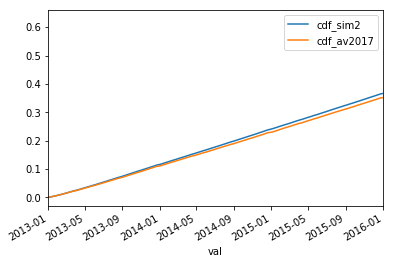

In [7]:
compute_stats.compute_cdf(pair, combined_counts['univariate_dates'][pair]).query("column_name == 'DATE_FIRST_SURGERY'").plot('val', ['cdf_'+key for key in pair],
                                                                                                              xlim=('2013', '2016'))
# pair = ('sim1', 'av2015')
# compute_cdf(pair, combined_counts['univariate_categorical'][pair].query("column_name == 'AGE'")).plot('val', ['cdf_'+key for key in pair])

## SQL implementation

We will add the following columns to our table to further analyse and compare the real and simulated datasets:
- The fraction/proportion of all entries in the corresponding table which take on a given value
- A normal approximation to a one-sample binomial test statistic, and a flag for whether the normal approximation is appropriate
- Pooled two-sample z-test statistics based on binomial assumptions
- Summands for computing Pearson's chi-squared and Likelihood-ratio test statistics

In [ ]:
analysis_df = pd.read_sql_query(queries.compute_stats_query(pop_queries['sim1'], pop_queries['av2015']), db)
print(analysis_df.shape)

# Test results: Pandas implementation + Plotly

In [8]:
interact(lambda col_name: plots.plot_univariate_categorical_results(univariate_z_test_results, col_name), col_name=field_list_dict['univariate_categorical'])

interactive(children=(Dropdown(description='col_name', options=('QUINTILE_2015', 'CREG_CODE', 'GRADE', 'SEX', …

<function __main__.<lambda>(col_name)>

## Repeat for bivariate categorical counts tables

In [9]:
interact(lambda col_name1, col_name2: plots.plot_bivariate_categorical_results(bivariate_z_test_results, col_name1, col_name2) 
         if col_name1 != col_name2 else plots.plot_univariate_categorical_results(univariate_z_test_results, col_name1),
         col_name1=field_list_dict['univariate_categorical'], col_name2=field_list_dict['univariate_categorical'])

interactive(children=(Dropdown(description='col_name1', options=('QUINTILE_2015', 'CREG_CODE', 'GRADE', 'SEX',…

<function __main__.<lambda>(col_name1, col_name2)>

## Kolmogorov-Smirnov tests for univariate counts

[Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov%E2%80%93Smirnov_test)

### By Age

### By Diagnosis Date

### By Date of First Surgery

In [ ]:
univariate_date_results = {date_type: univariate_results.loc[univariate_results.column_name == date_type, 
                                                             ['val'] + ['counts_'+key for key in key_list] + ['proportion_'+key for key in key_list]] 
                           for date_type in field_list_dict['univariate_dates']}

cumsum_results = pd.concat([univariate_date_results['DIAGNOSISDATEBEST'].val, univariate_date_results['DIAGNOSISDATEBEST'][['counts_'+key for key in key_list] + ['proportion_'+key for key in key_list]].cumsum()], axis=1)
cumsum_results['CDF_diff_sim1_av2015'] = (cumsum_results.proportion_sim1 - cumsum_results.proportion_av2015).abs()
cumsum_results['CDF_diff_sim2_av2017'] = (cumsum_results.proportion_sim2 - cumsum_results.proportion_av2017).abs()

In [ ]:
ks_raw = cumsum_results[['CDF_diff_sim1_av2015', 'CDF_diff_sim2_av2017']].max()
ks_normalized = dict()
ks_normalized['sim1_av2015'] = ks_raw[0] * np.sqrt((pop_sizes['sim1'] * pop_sizes['av2015'])/(pop_sizes['sim1'] + pop_sizes['av2015']))
ks_normalized['sim2_av2017'] = ks_raw[1] * np.sqrt((pop_sizes['sim2'] * pop_sizes['av2017'])/(pop_sizes['sim2'] + pop_sizes['av2017']))
print(ks_normalized)

In [ ]:
cumsum_results

In [ ]:
fig = go.Figure()
x_vals = cumsum_results['val_clean']
for key in key_list:
    y_vals = cumsum_results['proportion_'+key]
    fig.add_trace(go.Scatter(x=x_vals, y=y_vals, name="CDF: "+key))

fig.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)
fig.show()

# Test results: SQL implementation + matplotlib

## Table and plots - Sim1 vs. AV2015 cohort

In [ ]:
analysis_df = pd.read_sql_query(queries.compute_stats_query(pop_queries['sim1'], pop_queries['av2015']), db)
analysis_df.shape

In [ ]:
interact(lambda col_name: plots.view_by_field(analysis_df, col_name), col_name=col_names);

In [ ]:
interact(lambda col_name, plot_type: plots.plot_by_category(analysis_df, col_name, plot_type), 
         col_name=col_names, plot_type=plot_params_dict.keys());

## Results: Table and plots - Sim2 vs. AV2017 cohort

In [ ]:
analysis_df2 = pd.read_sql_query(queries.compute_stats_query(pop_queries['sim2'], pop_queries['av2017']), db)
analysis_df2.shape

In [ ]:
interact(lambda col_name: plots.view_by_field(analysis_df2, col_name), col_name=col_names);

In [ ]:
interact(lambda col_name, plot_type: plots.plot_by_category(analysis_df2, col_name, plot_type), 
         col_name=col_names, plot_type=plot_params_dict.keys());

# Evaluating the test results

In [ ]:
analysis_df.iloc[:,2:].abs().describe()

In [ ]:
analysis_df[['binom_z_test_one_sample', 'z_test_two_sample_pooled']].describe()

In [ ]:
analysis_df[['binom_z_test_one_sample', 'z_test_two_sample_pooled']].plot.box(vert=False, figsize=(15, 6))

In [ ]:
import numpy as np
from scipy.stats import norm
fig, axes = plt.subplots(2,1, figsize=(15,10))

# First plot standard normal distributions on both axes for reference
x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 100)
for ax in axes:
    ax.plot(x, norm.pdf(x), 'k')
# Now plot the histograms of test-statistic values
analysis_df[['binom_z_test_one_sample']].hist(bins=2500, density=True, ax=axes[0])
analysis_df[['z_test_two_sample_pooled']].hist(bins=2500, density=True, ax=axes[1])
# Set the limits for the x-axis
axes[0].set_xlim(-7,7);
axes[0].set_title('Histogram of one-sample z-test statistics over all categories in all fields', fontsize = 24);
axes[1].set_xlim(-7,7);
axes[1].set_title('Histogram of two-sample z-test statistics over all categories in all fields', fontsize = 24);

In [ ]:
import numpy as np
from scipy.stats import norm
fig, axes = plt.subplots(2,1, figsize=(15,10))

# First plot standard normal distributions on both axes for reference
x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 100)
for ax in axes:
    ax.plot(x, norm.pdf(x), 'k')
# Now plot the histograms of test-statistic values
analysis_df2[['binom_z_test_one_sample']].hist(bins=2500, density=True, ax=axes[0])
analysis_df2[['z_test_two_sample_pooled']].hist(bins=2500, density=True, ax=axes[1])
# Set the limits for the x-axis
axes[0].set_xlim(-7,7);
axes[0].set_title('Histogram of one-sample z-test statistics over all categories in all fields', fontsize = 24);
axes[1].set_xlim(-7,7);
axes[1].set_title('Histogram of two-sample z-test statistics over all categories in all fields', fontsize = 24);

In [ ]:
import numpy as np
from scipy.stats import norm
fig, ax = plt.subplots(1,1, figsize=(15,10))

# First plot standard normal distributions on both axes for reference
x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 100)
ax.plot(x, norm.pdf(x), 'k')
# Now plot the histograms of test-statistic values
analysis_df[['z_test_two_sample_pooled']].hist(bins=2500, density=True, ax=ax)
# Set the limits for the x-axis
ax.set_xlim(-7,7)
ax.set_title('Histogram of two-sample z-test statistics over all categories in all fields', fontsize = 24);

# Exporting plots and chi-squared calculations

In [ ]:
# variables = ['PERFORMANCESTATUS', 'CNS', 'ACE27', 'N_BEST']
# for variable in variables:
#     plots.plot_by_category(analysis_df, variable, 'Pooled Two-sample Binomial z-test')
#     plt.savefig("z_test_plot_{}.png".format(variable), transparent=False, dpi=300)

In [ ]:
grouped.sum().head()

In [ ]:
from scipy.stats import chisquare

analysis_df['f_exp'] = analysis_df.counts_r * (1402817/1462158)
chi2_tests = dict()
chi2_p_vals = dict()
for col_name in col_names:
    counts = analysis_df.loc[analysis_df.col_name == col_name]
    chi2_tests[col_name] = chisquare(counts['counts_s'], counts['f_exp'])[0]
    chi2_p_vals[col_name] = chisquare(counts['counts_s'], counts['f_exp'])[1]
results = pd.DataFrame([chi2_tests, chi2_p_vals]).T
results#.plot.bar(figsize=(15,10), ylim=(0, 0.01))

In [ ]:
grouped = analysis_df.groupby(by='col_name')
results = pd.concat([grouped.size(), grouped['pearson_summand'].sum(), 2 * grouped['lr_summand'].sum(), grouped.size() - 1], axis=1)
results.columns = ['num_cats', 'Pearson_chi2_test', 'Likelihood_ratio_test', 'degrees_of_freedom']
results

In [ ]:
# def myfunc(col_name):
#     return counts_tables['sim1'].loc[(counts_tables['sim1'].column_name == col_name)].plot.bar('val_clean', 'counts_sim1')
# interact(myfunc, col_name=col_names);